In [2]:
import pandas               as pd
import matplotlib.pyplot    as plt
import numpy                as np

training_image_path = 'datasets/training/'
training_tnf_csv    = 'training_data/tps'

train_pd = pd.read_csv(training_tnf_csv + '/train.csv') 

/var/folders/tl/_smmzcf56jn3pnwyc8ggqhdc0000gn/T/ipykernel_93075/2939674786.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transforms_pd = transforms_pd.append({
/var/folders/tl/_smmzcf56jn3pnwyc8ggqhdc0000gn/T/ipykernel_93075/2939674786.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transforms_pd = transforms_pd.append({
/var/folders/tl/_smmzcf56jn3pnwyc8ggqhdc0000gn/T/ipykernel_93075/2939674786.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transforms_pd = transforms_pd.append({
/var/folders/tl/_smmzcf56jn3pnwyc8ggqhdc0000gn/T/ipykernel_93075/2939674786.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transforms_pd =

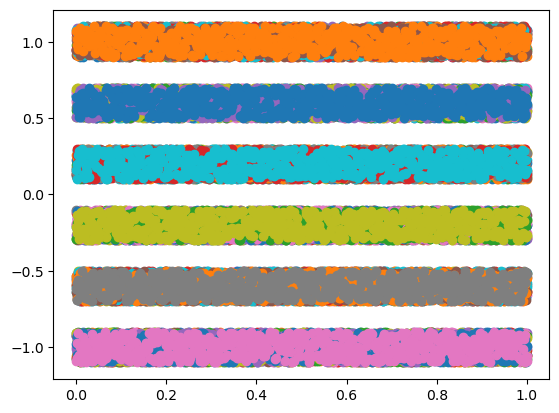

In [3]:
transforms_pd = pd.DataFrame(columns=['Parameter','Min','Max'])

# Find the min & max values of each parameter
for i in range(1,73):
    name = 't' + str(i)
    data = train_pd[name]
    plt.scatter(np.linspace(0, 1, len(data)), data)
    
    transforms_pd = transforms_pd.append({
        'Parameter': name, 
        'Min':       np.amin(data), 
        'Max':       np.amax(data)    
        }, ignore_index=True)

In [4]:
def random_transform(pd, image_name):
    """
    Create a random transform by sampling from each parameter. 
    Assume a uniform distribution between min & max values.
    """
    
    output = {}
    output['ImageA'] = image_name
    output['ImageB'] = image_name
    
    for i in range(1,73):
        name    = 't' + str(i)
        row     = pd[pd['Parameter']==name]
        value   = np.random.uniform(row['Min'], row['Max'])[0]
        output[name] = [value]
        
    return output

Add MRI and Histology images

In [7]:
file_names = ['HMU_011_MQ', 'HMU_025_SH']

in_vivo = {
    'HMU_003_DB': [20,19,12],
    'HMU_007_TN': [19,18,16],
    'HMU_010_FH' : [19,17,13,12],
    'HMU_011_MQ': [18,12,10,9],
    'HMU_025_SH': [22,19,15]
}

histo = {
    'HMU_003_DB': ['A2','A3','A5'],
    'HMU_007_TN': ['A1','A2','A3'],
    'HMU_010_FH': ['A2','A3','A5','A6'],
    'HMU_011_MQ': ['A4','A7','A8','A9'],
    'HMU_025_SH': ['A1','A3','A5']
}

updated_train_pd = train_pd.copy()
number_samples   = 0

for name in file_names:
    # MRI 
    mri_slices = in_vivo[name]
    for slice in mri_slices:
        image_name  = 'mri_' + name + '_' + str(slice) + '.png'
        new_row     = random_transform(transforms_pd, image_name)
        
        new_row_pd       = pd.DataFrame.from_dict(new_row)
        updated_train_pd = pd.concat((updated_train_pd, new_row_pd), ignore_index=True)
        
        number_samples += 1
       
    # Histology 
    histo_slices = in_vivo[name]
    for slice in histo_slices:
        image_name  = name + str(slice) + '_histo_downsampled.png'
        new_row     = random_transform(transforms_pd, image_name)
        
        new_row_pd       = pd.DataFrame.from_dict(new_row)
        updated_train_pd = pd.concat((updated_train_pd, new_row_pd), ignore_index=True)
        
        number_samples += 1

print(number_samples)
updated_train_pd


14


,ImageA,ImageB,t1,t2,t3,t4,t5,t6,t7,t8,...,t63,t64,t65,t66,t67,t68,t69,t70,t71,t72
0,hist_TCIA-0001_slice1.png,hist_TCIA-0001_slice1.png,-0.928000,-1.060000,-1.080000,-1.070000,-0.925000,-0.917000,-0.549000,-0.536000,...,-0.290000,0.163000,0.510000,0.949000,-1.090000,-0.622000,-0.210000,0.162000,0.636000,1.070000
1,hist_TCIA-0001_slice2.png,hist_TCIA-0001_slice2.png,-0.911000,-0.973000,-0.904000,-1.040000,-0.913000,-0.986000,-0.579000,-0.649000,...,-0.279000,0.296000,0.557000,1.000000,-1.070000,-0.694000,-0.134000,0.103000,0.555000,0.981000
2,hist_TCIA-0002_slice1.png,hist_TCIA-0002_slice1.png,-1.030000,-0.908000,-0.999000,-0.960000,-1.030000,-0.909000,-0.521000,-0.689000,...,-0.185000,0.257000,0.626000,1.070000,-0.972000,-0.577000,-0.250000,0.202000,0.578000,1.020000
3,hist_TCIA-0002_slice2.png,hist_TCIA-0002_slice2.png,-0.926000,-1.050000,-0.901000,-0.958000,-0.931000,-0.987000,-0.545000,-0.667000,...,-0.184000,0.214000,0.626000,1.040000,-0.910000,-0.562000,-0.172000,0.261000,0.548000,0.950000
4,hist_TCIA-0004_slice1.png,hist_TCIA-0004_slice1.png,-1.010000,-1.020000,-0.930000,-0.978000,-1.050000,-0.966000,-0.523000,-0.594000,...,-0.157000,0.167000,0.667000,1.030000,-1.050000,-0.585000,-0.292000,0.286000,0.507000,1.040000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619,mri_HMU_025_SH_19.png,mri_HMU_025_SH_19.png,-0.907466,-0.972032,-1.004531,-1.070433,-1.017671,-1.046383,-0.675964,-0.577298,...,-0.249438,0.182207,0.684272,1.077235,-1.027305,-0.604865,-0.227259,0.216118,0.650595,0.998284
620,mri_HMU_025_SH_15.png,mri_HMU_025_SH_15.png,-1.080072,-0.937849,-0.953528,-0.973071,-0.910517,-0.965265,-0.609635,-0.601824,...,-0.178478,0.228064,0.613923,0.954199,-1.093968,-0.570804,-0.194049,0.147778,0.638395,0.986000
621,HMU_025_SH22_histo_downsampled.png,HMU_025_SH22_histo_downsampled.png,-1.020470,-0.943881,-0.948786,-0.908563,-0.950633,-0.927182,-0.581200,-0.690635,...,-0.148619,0.191447,0.536183,0.905896,-1.024609,-0.653193,-0.268189,0.282237,0.517621,0.908938
622,HMU_025_SH19_histo_downsampled.png,HMU_025_SH19_histo_downsampled.png,-0.937818,-1.070756,-1.084556,-1.037847,-0.983665,-0.973788,-0.671715,-0.584373,...,-0.106054,0.218231,0.667942,0.920658,-0.906609,-0.674928,-0.177731,0.255210,0.689192,0.934080


In [9]:
updated_train_pd.to_csv('training_data/tps/train_updated.csv', index=False)